In [25]:
## Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

In [2]:
## Reading the input file

excel_path = "/kaggle/input/liar-dataset-labeled/liar_data.xlsx"
df_train = pd.read_excel(excel_path, sheet_name="train")
df_val = pd.read_excel(excel_path, sheet_name="test")
df_test = pd.read_excel(excel_path, sheet_name="val")

In [3]:
## For the sake of demonstration, I'm combining all the 3 datasets into 1

df = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)
df.head()
df.dtypes

,ID,Label,Text,Subject,Speaker,Job,State,Party,BT,F,HT,MT,POF,Context
0,1,pants-fire,The attorney general requires that rape victim...,"crime,women",barbara-ann-radnofsky,NaN,NaN,democrat,0.0,0.0,0.0,0.0,1.0,in a Web site video
1,2,half-true,President Clinton reduced the scale of our mil...,military,mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,"a Republican debate in Orlando, Fla."
2,4,mostly-true,"I used tax cuts to help create over 80,000 job...",taxes,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,a TV Ad.
3,5,mostly-true,"New Mexico moved ""up to"" sixth in the nation i...",job-accomplishments,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,a TV Ad.
4,7,True,"Corporate profits are up, CEO pay is up, but a...",economy,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,"Washington, DC"


In [4]:
## Simplifying the number of categories into 3 - False (2), Half-True (1), True (0)

df['Label'] = df['Label'].astype(str)
df['Label'] = df['Label'].str.lower()

label_mapping = {'true': 0, 'mostly-true': 0, 'half-true': 1, 'barely-true': 2, 'false': 2, 'pants-fire': 2}
df['Label'] = df['Label'].map(label_mapping)

print(df.shape)
df.head()

(12836, 14)


,ID,Label,Text,Subject,Speaker,Job,State,Party,BT,F,HT,MT,POF,Context
0,1,2,The attorney general requires that rape victim...,"crime,women",barbara-ann-radnofsky,NaN,NaN,democrat,0.0,0.0,0.0,0.0,1.0,in a Web site video
1,2,1,President Clinton reduced the scale of our mil...,military,mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,"a Republican debate in Orlando, Fla."
2,4,0,"I used tax cuts to help create over 80,000 job...",taxes,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,a TV Ad.
3,5,0,"New Mexico moved ""up to"" sixth in the nation i...",job-accomplishments,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,a TV Ad.
4,7,0,"Corporate profits are up, CEO pay is up, but a...",economy,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,"Washington, DC"


## Exploratory Data Analysis

In [5]:
# Check for duplicate rows
df.duplicated().sum()

0

In [6]:
# Check for missing values
df.isnull().sum()

ID            0
Label         0
Text          0
Subject       8
Speaker       8
Job        3582
State      2760
Party         8
BT            8
F             8
HT            8
MT            8
POF           8
Context     137
dtype: int64

In [7]:
## 8 rows have multiple columns missing, so its safe to remove them from the dataset.
df = df.dropna(subset=['Subject'])

## filling the rest with a new category
df['Job'] = df['Job'].fillna('Missing')
df['State'] = df['State'].fillna('Missing')
df['Context'] = df['Context'].fillna('Missing')

## ID column is just an index variable. 
df = df.drop("ID", axis=1)

print(df.isnull().sum())

Label      0
Text       0
Subject    0
Speaker    0
Job        0
State      0
Party      0
BT         0
F          0
HT         0
MT         0
POF        0
Context    0
dtype: int64


In [8]:
print("\nLabel distribution:")
print(df['Label'].value_counts())


Label distribution:
Label
2    5665
0    4526
1    2637
Name: count, dtype: int64


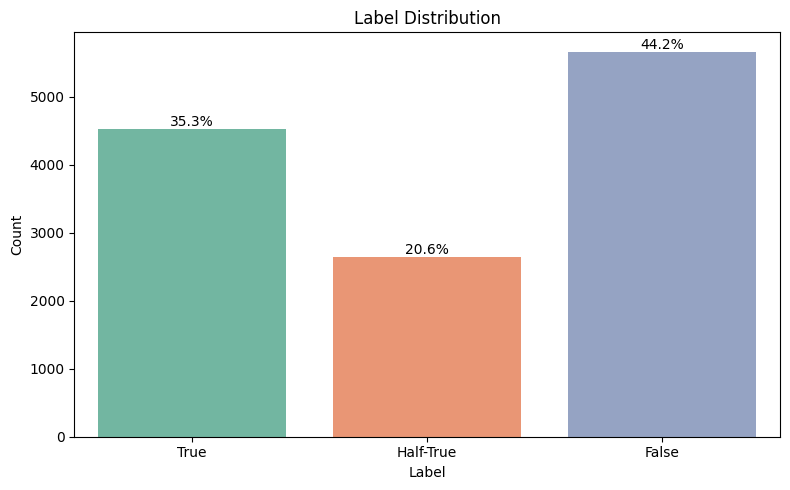

In [9]:
# Plot label distribution

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='Label', palette='Set2')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['True', 'Half-True', 'False'])
total = len(df['Label'])
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center',
                va='bottom',
                fontsize=10)
plt.tight_layout()
plt.show()

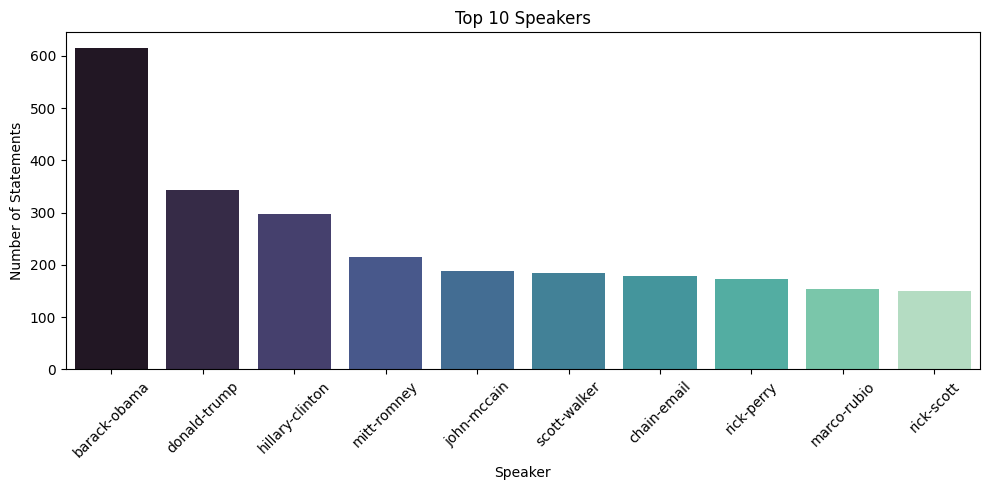

In [10]:
# Speaker-wise most frequent

top_speakers = df['Speaker'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette='mako')
plt.title('Top 10 Speakers')
plt.xticks(rotation=45)
plt.ylabel('Number of Statements')
plt.tight_layout()
plt.show()

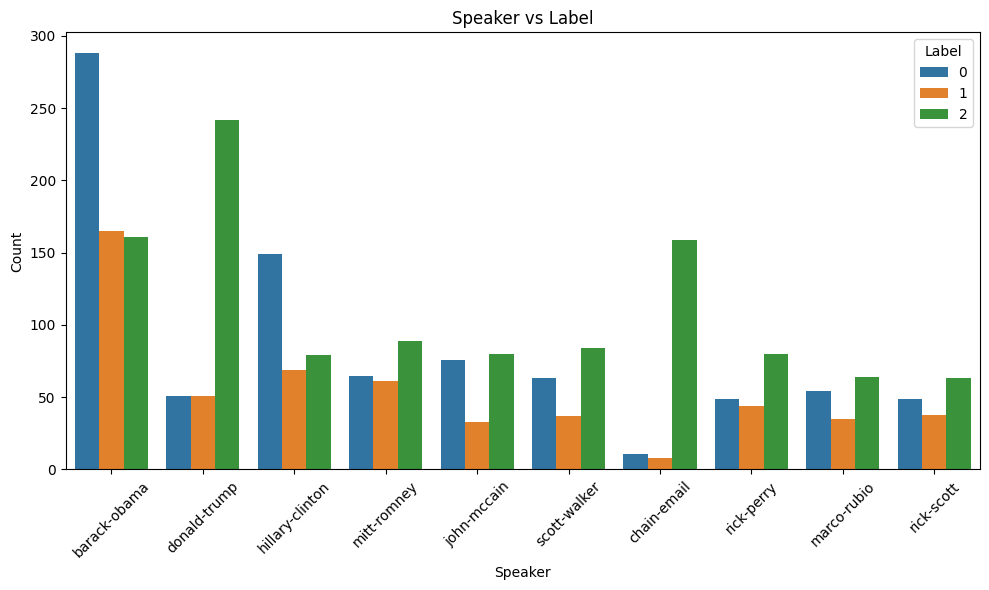

In [16]:
# Speaker vs label

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Speaker', hue='Label', order=df['Speaker'].value_counts().head(10).index)
plt.title('Speaker vs Label')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

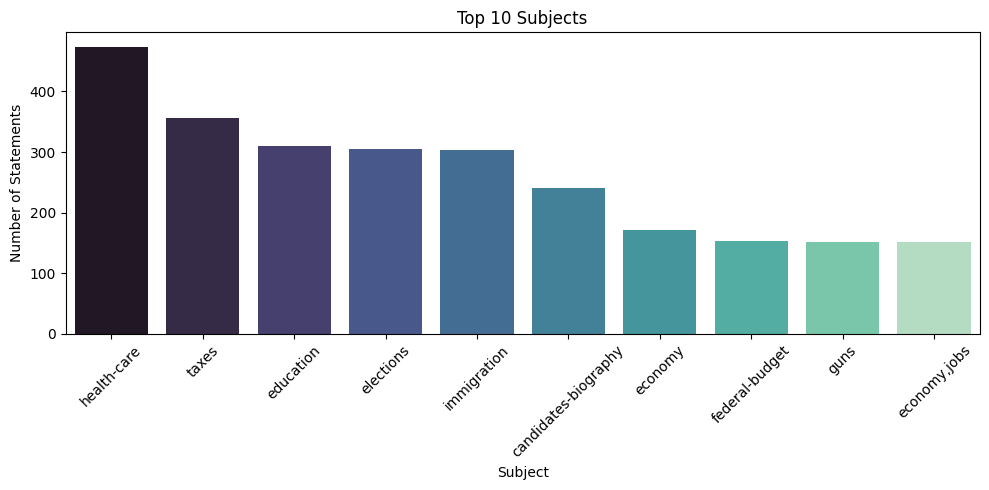

In [11]:
# Most spoken about subjects

top_speakers = df['Subject'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette='mako')
plt.title('Top 10 Subjects')
plt.xticks(rotation=45)
plt.ylabel('Number of Statements')
plt.tight_layout()
plt.show()

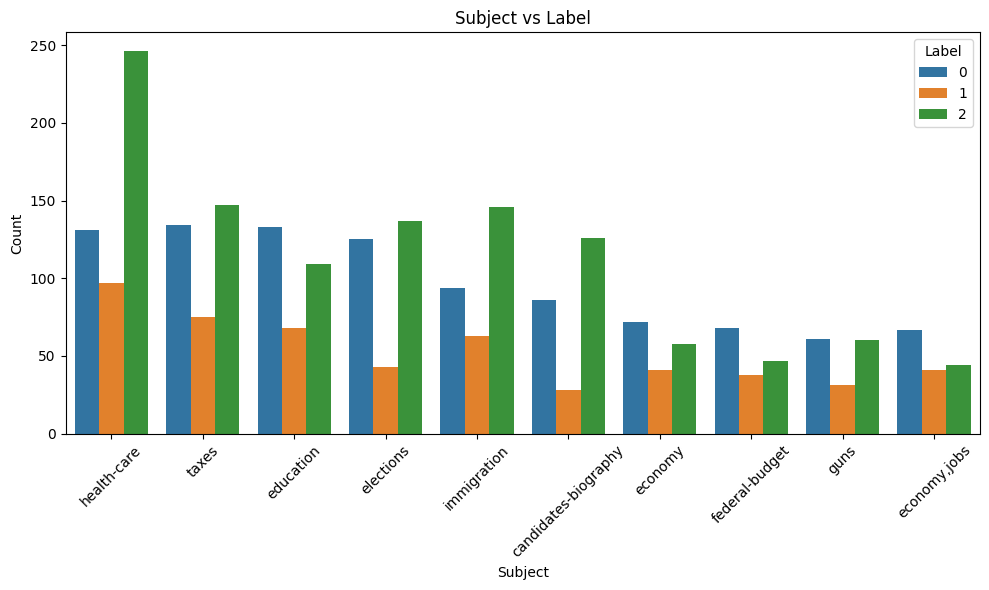

In [13]:
# Subject vs label

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Subject', hue='Label', order=df['Subject'].value_counts().head(10).index)
plt.title('Subject vs Label')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

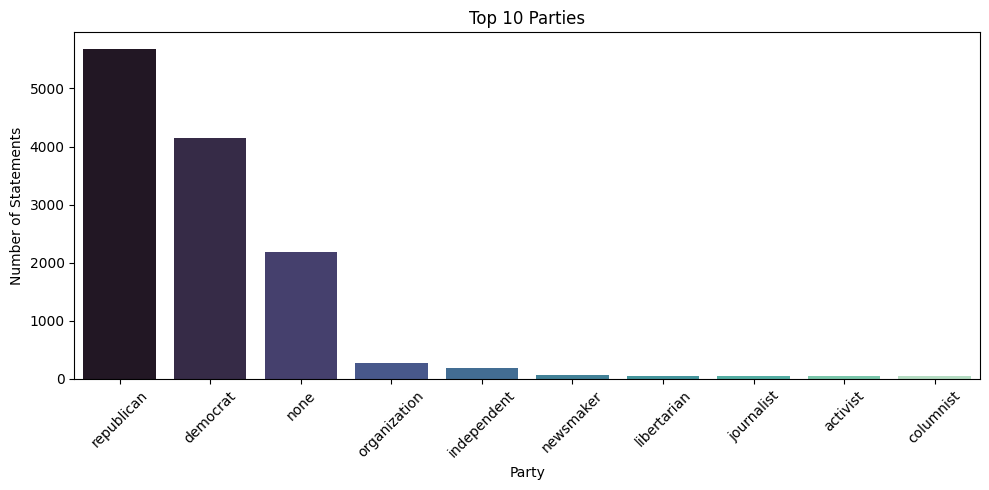

In [12]:
# Party wise frequency

top_speakers = df['Party'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette='mako')
plt.title('Top 10 Parties')
plt.xticks(rotation=45)
plt.ylabel('Number of Statements')
plt.tight_layout()
plt.show()

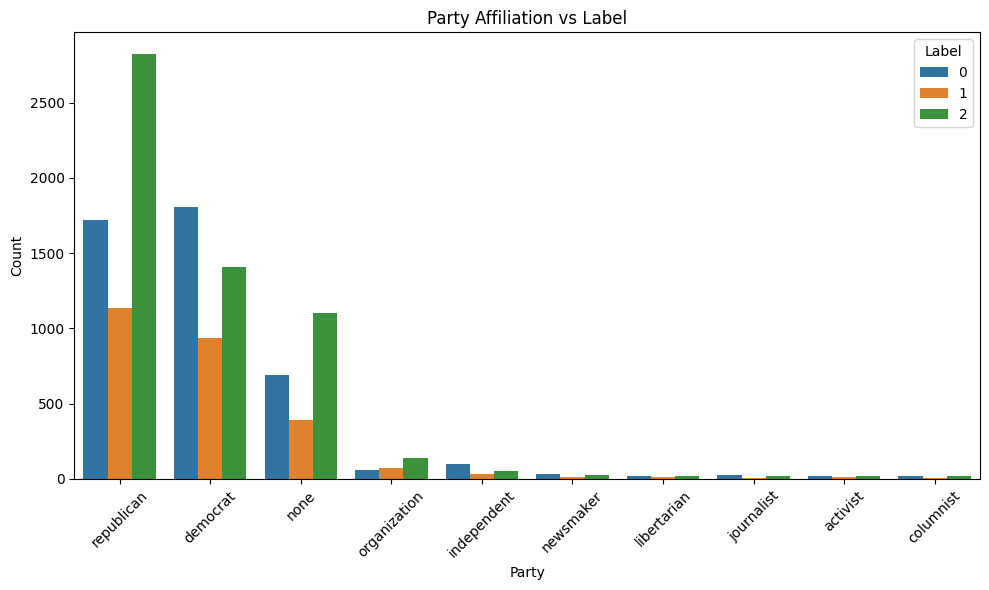

In [14]:
# Party affiliation vs label

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Party', hue='Label', order=df['Party'].value_counts().head(10).index)
plt.title('Party Affiliation vs Label')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


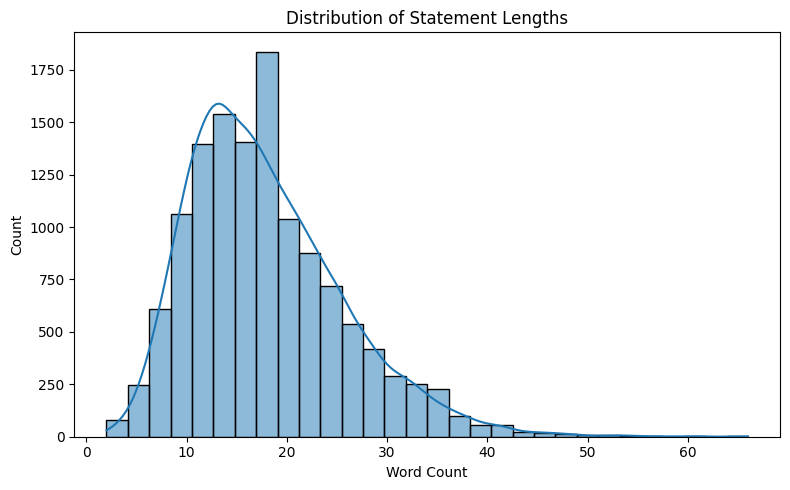

In [15]:
df['text_len'] = df['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

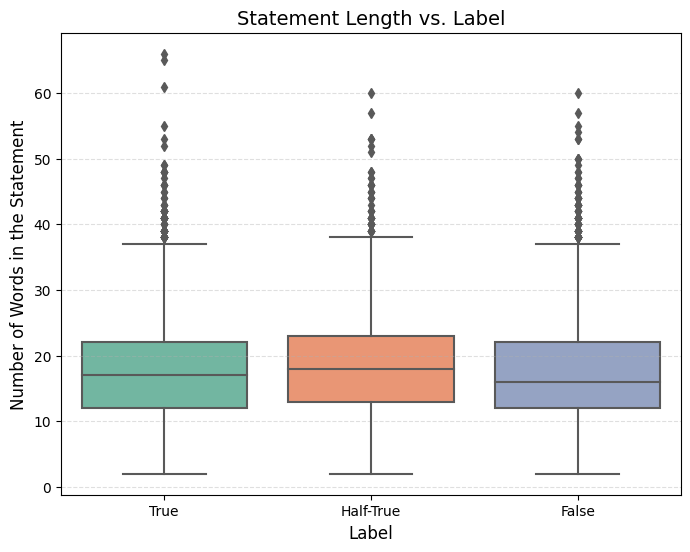

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="Label",
    y="text_len",
    palette="Set2"
)
plt.title("Statement Length vs. Label", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Number of Words in the Statement", fontsize=12)
plt.xticks([0, 1, 2], ['True', 'Half-True', 'False'])
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

## Feature Engineering and Extraction

In [18]:
df['total'] = df['F'] + df['BT'] + df['HT'] + df['POF'] + df['MT']
df['perc_F'] = (df['F']+df['BT']+df['POF'])/df['total']
df['perc_HT'] = df['HT']/df['total']
df['perc_T'] = df['MT']/df['total']

df['perc_F'] = df['perc_F'].fillna(0)
df['perc_HT'] = df['perc_HT'].fillna(0)
df['perc_T'] = df['perc_T'].fillna(0)

In [19]:
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [21]:
df['clean_text'] = df['Text'].apply(clean_text)
df.head()

,Label,Text,Subject,Speaker,Job,State,Party,BT,F,HT,MT,POF,Context,text_len,total,perc_F,perc_HT,perc_T,clean_text
0,2,The attorney general requires that rape victim...,"crime,women",barbara-ann-radnofsky,Missing,Missing,democrat,0.0,0.0,0.0,0.0,1.0,in a Web site video,12,1.0,1.000000,0.000000,0.000000,attorney gener requir rape victim pay rape kit
1,1,President Clinton reduced the scale of our mil...,military,mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,"a Republican debate in Orlando, Fla.",9,176.0,0.482955,0.329545,0.187500,presid clinton reduc scale militari dramat
2,0,"I used tax cuts to help create over 80,000 job...",taxes,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,a TV Ad.,13,15.0,0.266667,0.200000,0.533333,use tax cut help creat job new mexico
3,0,"New Mexico moved ""up to"" sixth in the nation i...",job-accomplishments,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,a TV Ad.,12,15.0,0.266667,0.200000,0.533333,new mexico move sixth nation job growth
4,0,"Corporate profits are up, CEO pay is up, but a...",economy,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,"Washington, DC",15,221.0,0.343891,0.312217,0.343891,corpor profit ceo pay averag wage american flat


### Extracting TF-IDF features.

This is a vectorization process which converts smaller pieces of words (tokens) into numbers for easier modeling.

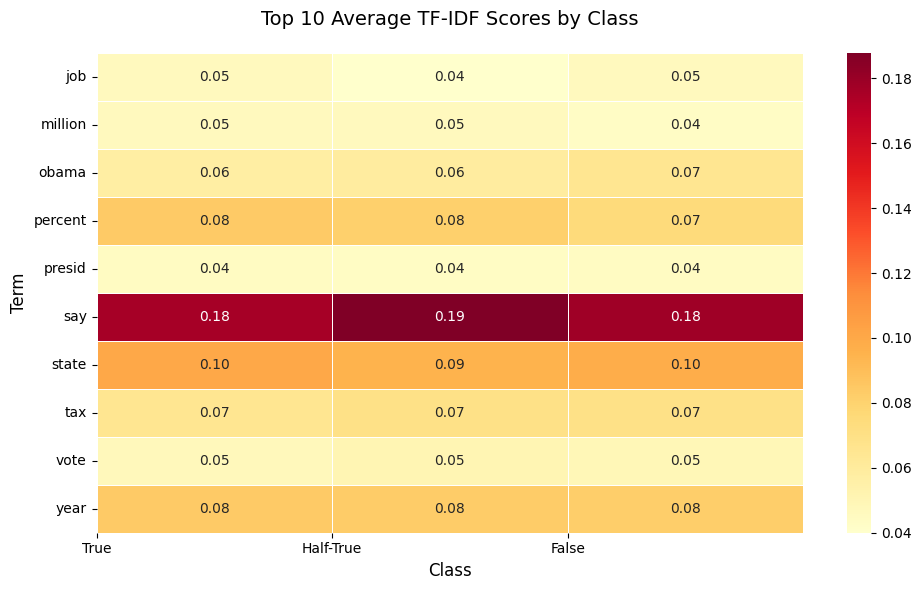

In [23]:
vectorizer2 = TfidfVectorizer(max_features=10)
tfidf_df = pd.DataFrame(vectorizer2.fit_transform(df['clean_text']).toarray(), columns=vectorizer2.get_feature_names_out())

# Add labels and group
tfidf_df['Label'] = df['Label']
mean_tfidf = tfidf_df.groupby('Label').mean().T

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(mean_tfidf, cmap="YlOrRd", annot=True, fmt=".2f", linewidths=.5)
plt.title("Top 10 Average TF-IDF Scores by Class", fontsize=14, pad=20)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Term", fontsize=12)
plt.xticks([0, 1, 2], ['True', 'Half-True', 'False'])
plt.tight_layout()
# plt.savefig("tfidf_heatmap.png", dpi=300, bbox_inches='tight')

## Model Building

In [26]:
X = df.drop(["Label","Text","Job","State","Party","Context","F","BT","HT","MT","POF","Speaker","Subject"], axis=1)
y = df["Label"]

vectorizer = TfidfVectorizer(max_features=5000)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6314)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, "clean_text"),                                     # TF-IDF vectorization for cleaned text
        ("num", StandardScaler(), ["perc_F", "perc_HT", "perc_T", "total", "text_len"]),    # Scale numeric
        ## ("cat", OneHotEncoder(), ["Speaker", "Subject"])  # One-hot encode categorical
    ],
    sparse_threshold=0.3  # Optimize for sparse (TF-IDF) + dense (metadata)
)

### Logistic Regression Model

The model is built using the TF-IDF features only.

In [29]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500))  # Efficient for sparse + dense
])

In [30]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['perc_F', 'perc_HT',
                                                   'perc_T', 'total',
                                                   'text_len'])])),
                ('classifier',
                 LogisticRegression(max_iter=500, multi_class='multinomial'))])

              precision    recall  f1-score   support

        True       0.60      0.63      0.62       877
   Half-True       0.55      0.39      0.46       520
       False       0.69      0.76      0.72      1169

    accuracy                           0.64      2566
   macro avg       0.62      0.59      0.60      2566
weighted avg       0.63      0.64      0.63      2566



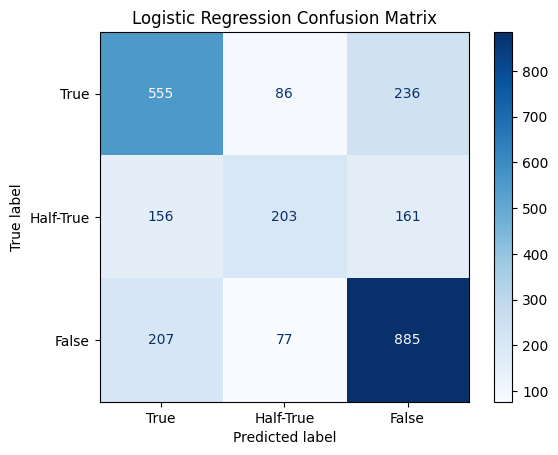

In [31]:
# Predict on test set
y_pred_test = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_test, target_names=["True", "Half-True", "False"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1,2])  

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Half-True", "False"])
disp.plot(cmap="Blues", values_format="d")  # 'd' for integer formatting
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [32]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

coefs = model.named_steps['classifier'].coef_
if len(coefs.shape) > 1:  # Multiclass
    coefs = coefs[2]  ## Feature importance for false class only

if hasattr(coefs, 'toarray'):
    coefs = coefs.toarray().flatten()

top_features = sorted(zip(feature_names, np.abs(coefs)),
                     key=lambda x: x[1], reverse=True)[:10]

print("Top Predictive Features (Logistic Regression):")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")

Top Predictive Features (Logistic Regression):
text__idea: 1.3308
text__youv: 1.3222
text__drop: 1.3141
text__real: 1.2219
text__rep: 1.2203
text__percent: 1.1863
text__half: 1.1820
text__convict: 1.1706
text__white: 1.1693
text__american: 1.1032


### Support Vector Machine

The model is built using the TF-IDF features only.

In [34]:
from sklearn.svm import SVC

svm_model = Pipeline([
    ("preprocessor", preprocessor),  # Same ColumnTransformer (TF-IDF + metadata)
    ("classifier", SVC(
        kernel="linear",  # Best for high-dimensional text data
        C=1.0,           # Regularization parameter (tune this)
        probability=True  # Required for predict_proba()
    ))
])

In [35]:
svm_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['perc_F', 'perc_HT',
                                                   'perc_T', 'total',
                                                   'text_len'])])),
                ('classifier', SVC(kernel='linear', probability=True))])

              precision    recall  f1-score   support

        True       0.58      0.64      0.61       877
   Half-True       0.57      0.37      0.45       520
       False       0.69      0.74      0.71      1169

    accuracy                           0.63      2566
   macro avg       0.61      0.59      0.59      2566
weighted avg       0.63      0.63      0.63      2566



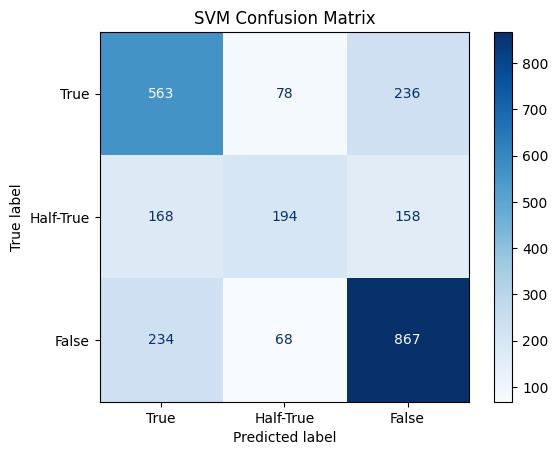

In [36]:
# Predict on test set
y_pred = svm_model.predict(X_test)

# Classification report
print(classification_report(
    y_test, 
    y_pred, 
    target_names=["True", "Half-True", "False"]  
))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    svm_model,
    X_test,
    y_test,
    display_labels=["True", "Half-True", "False"],
    cmap="Blues"
)
plt.title("SVM Confusion Matrix")
plt.show()

In [38]:
importance = abs(svm_model.named_steps["classifier"].coef_[0])
feature_names = svm_model.named_steps['preprocessor'].get_feature_names_out()
coefs = svm_model.named_steps['classifier'].coef_[2]  # For class 2 false

if hasattr(coefs, 'toarray'):
    coefs = coefs.toarray().flatten()

top_features = sorted(zip(feature_names, np.abs(coefs)),
                     key=lambda x: x[1], 
                     reverse=True)[:5]

print("Top Predictive Features:")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")

Top Predictive Features:
text__santorum: 2.3761
text__indiana: 2.0447
text__idea: 1.7744
text__doctor: 1.7440
text__nevada: 1.6053


### Long Short Term Memory Model

This model uses tokenized raw data as well as other numerical metadata without TF-IDF features.  

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text
tokenizer = Tokenizer(num_words=5000)  # Keep top 5K words
tokenizer.fit_on_texts(X_train["clean_text"])
X_text = tokenizer.texts_to_sequences(X_train["clean_text"])
X_text = pad_sequences(X_text, maxlen=100)  # Pad to 100 tokens

X_meta = StandardScaler().fit_transform(X_train[["perc_F", "perc_HT", "perc_T", "total", "text_len"]])
X_final = np.concatenate([X_text, X_meta], axis=1)

2025-07-13 04:58:39.148292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752382719.421981      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752382719.508901      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [42]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, meta_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim + meta_dim, num_classes)  # Combine LSTM + metadata

    def forward(self, x_text, x_meta):
        embedded = self.embedding(x_text)
        lstm_out, _ = self.lstm(embedded)
        lstm_features = lstm_out[:, -1, :]  # Last timestep
        combined = torch.cat([lstm_features, x_meta], dim=1)
        return self.fc(combined)


In [43]:
model = LSTMModel(
    vocab_size=5000,    # Match Tokenizer's num_words
    embedding_dim=100,
    hidden_dim=64,
    num_classes=3,      # 3 classes
    meta_dim=X_meta.shape[1]  # Total metadata dims
)

In [44]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_text_tensor = torch.LongTensor(X_text)
X_meta_tensor = torch.FloatTensor(X_meta)
y_tensor = torch.LongTensor(y_train)  # y must be numeric labels (0, 1, 2)

# Create DataLoader
dataset = TensorDataset(X_text_tensor, X_meta_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    for x_text, x_meta, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(x_text, x_meta)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

In [45]:
X_text_test = tokenizer.texts_to_sequences(X_test["clean_text"])
X_text_test = pad_sequences(X_text_test, maxlen=100)  # Pad to 100 tokens

X_meta_test = StandardScaler().fit_transform(X_test[["perc_F", "perc_HT", "perc_T", "total", "text_len"]])

X_final_test = np.concatenate([X_text_test, X_meta_test], axis=1)

In [46]:
X_test_text_tensor = torch.LongTensor(X_text_test)
X_test_meta_tensor = torch.FloatTensor(X_meta_test)
y_test_tensor = torch.LongTensor(y_test.values)

              precision    recall  f1-score   support

        True       0.51      0.51      0.51       877
   Half-True       0.43      0.31      0.36       520
       False       0.61      0.70      0.65      1169

    accuracy                           0.55      2566
   macro avg       0.52      0.50      0.51      2566
weighted avg       0.54      0.55      0.54      2566



Text(0.5, 1.0, 'LSTM Confusion Matrix')

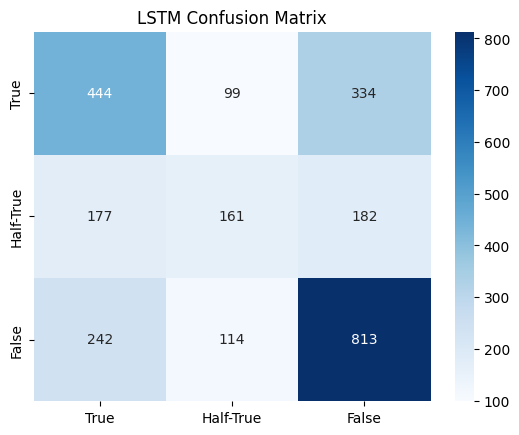

In [47]:
with torch.no_grad():
    model.eval()
    logits = model(X_test_text_tensor, X_test_meta_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test, y_pred, target_names=["True", "Half-True", "False"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["True", "Half-True", "False"], yticklabels=["True", "Half-True", "False"], cmap="Blues")
plt.title("LSTM Confusion Matrix")

### Long Short Term Memory Model 2

This model uses only the raw tokenized features. 

In [48]:
# 1. Preprocess Text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['clean_text'])  # train_texts = list of sentences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train['clean_text']), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test['clean_text']), maxlen=100)

# 2. Convert to PyTorch Tensors
X_train = torch.LongTensor(X_train)
X_test = torch.LongTensor(X_test)
y_train = torch.LongTensor(y_train)  
y_test = torch.LongTensor(y_test.values)

In [49]:
# 3. Define LSTM Model
class TextLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(5000, 128)  # vocab_size, embedding_dim
        self.lstm = nn.LSTM(128, 64, batch_first=True)  # embedding_dim, hidden_dim
        self.fc = nn.Linear(64, 3)  # hidden_dim, num_classes
        
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden.squeeze(0))

model = TextLSTM()

In [50]:
# 4. Train
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_data = TensorDataset(X_train, y_train)
loader = DataLoader(train_data, batch_size=32, shuffle=True)

for epoch in range(20):
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

Test Accuracy: 0.4170
              precision    recall  f1-score   support

        True       0.39      0.40      0.39       877
   Half-True       0.23      0.20      0.21       520
       False       0.51      0.53      0.52      1169

    accuracy                           0.42      2566
   macro avg       0.38      0.38      0.38      2566
weighted avg       0.41      0.42      0.41      2566



<Axes: >

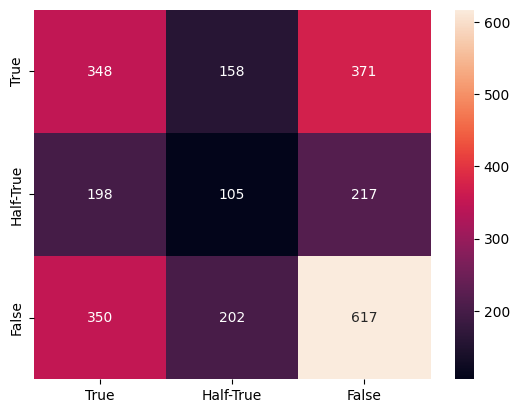

In [51]:
# 5. Evaluate
with torch.no_grad():
    test_outputs = model(X_test)
    predictions = torch.argmax(test_outputs, dim=1)
    accuracy = (predictions == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(y_test, predictions, target_names=["True", "Half-True", "False"]))

cm = confusion_matrix(y_test, predictions, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["True", "Half-True", "False"], yticklabels=["True", "Half-True", "False"])